# Neural Network approach

## Getting the dataset  ready

In [3]:
import pandas as pd
my_csv = pd.read_csv(r"D:\Programming shit\Python\MachineLearningDatasets\creditcard.csv")

In [37]:
import numpy as np
my_csv['split'] = np.random.randn(my_csv.shape[0], 1)

In [38]:
selection = np.random.rand(len(my_csv)) <= 0.85

In [39]:
train_csv = my_csv[selection]
test_csv = my_csv[~selection]

In [40]:
transaction_data_train = train_csv.drop(columns = ['Class','split'])
transaction_data_test = test_csv.drop(columns = ['Class','split'])

In [41]:
transaction_labels_train = train_csv['Class']
transaction_labels_test = test_csv['Class']

In [58]:
import torch
from sklearn.preprocessing import StandardScaler

class myDataset(torch.utils.data.Dataset):
    def __init__(self,transactions,labels):
        super().__init__()
        t = transactions.values
        l = labels.values
        scaler = StandardScaler()
        t = scaler.fit_transform(t)
        self.labels_list = torch.tensor(l)
        self.transactions_list = torch.tensor(t,dtype = torch.float32)
        
    def __len__(self):
        return len(self.labels_list)
    
    def __getitem__(self,index):
        return self.transactions_list[index], self.labels_list[index]


In [59]:
training_data = myDataset(transaction_data_train,transaction_labels_train) 
testing_data = myDataset(transaction_data_test,transaction_labels_test) 

In [60]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=1000, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=1000, shuffle=True)

## Defining the network(research in progress)

In [61]:
import torch.nn as nn

class MyDAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features = 30, out_features = 21)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(in_features = 21, out_features = 14)
        self.layer3= nn.Linear(in_features = 14, out_features = 9)
        self.layer4= nn.Linear(in_features = 9, out_features = 14)
        self.layer5= nn.Linear(in_features = 14, out_features = 21)
        self.layer6= nn.Linear(in_features = 21, out_features = 30)
        
    def forward(self,x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.relu(self.layer4(x))
        x = self.relu(self.layer5(x))
        x = self.relu(self.layer6(x))
        return x

In [62]:
class CardNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.dae = MyDAE()
        self.relu = nn.ReLU()
        self.soft = nn.Softmax()
        self.layer1 = nn.Linear(in_features = 30, out_features = 20)
        self.layer2 = nn.Linear(in_features = 20, out_features = 15)
        self.layer3 = nn.Linear(in_features = 15, out_features = 10)
        self.layer4 = nn.Linear(in_features = 10, out_features = 5)
        self.layer5 = nn.Linear(in_features = 5, out_features = 2)
        
    def forward(self,x):
        x = self.dae(x)
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.relu(self.layer4(x))
        x = self.soft(self.layer5(x))
        return x

## Actual training

In [79]:
import torch.optim as optim

epochs = 50

cardNet = CardNet()

optimizer = optim.Adam(params= cardNet.parameters(),lr = 1e-4)

optimizer.zero_grad()

CEloss = nn.CrossEntropyLoss()

In [80]:
def compute_accuracy(net: nn.Module, test_loader: DataLoader):
    net.eval()
    total = 0
    correct = 0
    for test_transaction, test_labels in test_loader:
        total += len(test_transaction)
        out_class = torch.argmax(net(test_transaction))
        correct += torch.sum(out_class == test_labels)

    return correct / total * 100

In [81]:
for e in range(epochs):
    cardNet.train()
    for transaction, labels in train_dataloader:
        out = cardNet(transaction)
        #labels = torch.reshape(labels)
        loss = CEloss(out, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print("Loss-ul la finalul epocii {} are valoarea {}".format(e + 1, loss.item()))
    acc = compute_accuracy(cardNet, test_dataloader)
    print("Acuratetea la finalul epocii {} este {:.2f}%".format(e + 1, acc))

C:\Users\Bogdan\AppData\Local\Temp/ipykernel_8804/2763871701.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.soft(self.layer5(x))


Loss-ul la finalul epocii 1 are valoarea 0.5417119264602661
Acuratetea la finalul epocii 1 este 0.00%
Loss-ul la finalul epocii 2 are valoarea 0.500148355960846
Acuratetea la finalul epocii 2 este 0.00%
Loss-ul la finalul epocii 3 are valoarea 0.31549713015556335
Acuratetea la finalul epocii 3 este 0.00%
Loss-ul la finalul epocii 4 are valoarea 0.3135438561439514
Acuratetea la finalul epocii 4 este 0.00%
Loss-ul la finalul epocii 5 are valoarea 0.31344470381736755
Acuratetea la finalul epocii 5 este 2.33%
Loss-ul la finalul epocii 6 are valoarea 0.3133328855037689
Acuratetea la finalul epocii 6 este 2.33%
Loss-ul la finalul epocii 7 are valoarea 0.31327345967292786
Acuratetea la finalul epocii 7 este 4.67%
Loss-ul la finalul epocii 8 are valoarea 0.31327056884765625
Acuratetea la finalul epocii 8 este 6.50%
Loss-ul la finalul epocii 9 are valoarea 0.31326526403427124
Acuratetea la finalul epocii 9 este 18.67%
Loss-ul la finalul epocii 10 are valoarea 0.3132641315460205
Acuratetea la fi

# KNN approach

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [4]:
my_csv3 = pd.read_csv(r"D:\Programming shit\Python\MachineLearningDatasets\creditcard.csv")

In [5]:
transactions = my_csv2.iloc[:,0:30]
labels = my_csv2.iloc[:,30]
training_transactions, testing_transactions,training_labels,testing_labels = train_test_split(transactions,labels,test_size = .15)

In [6]:
transactions_scaling = StandardScaler()
training_transactions = transactions_scaling.fit_transform(training_transactions)
testing_transactions = transactions_scaling.fit_transform(testing_transactions)

In [7]:
from math import sqrt,trunc
import datetime
def checkprime(x):
    for j in range(2,trunc(sqrt(x))):
        if x%j == 0:
            return False
    return True
f1_scores = []
k_values = []
accuracy_scores = []
for i in range(trunc(sqrt(sqrt(training_transactions.shape[0]))),trunc(sqrt(training_transactions.shape[0]))):
    if checkprime(i):
        k_values.append(i)
        
        
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors = k,p = 2,metric = 'euclidean')
    knn.fit(training_transactions,training_labels)
    predicted_labels = knn.predict(testing_transactions)
    f1_scores.append(f1_score(testing_labels,predicted_labels))
    accuracy_scores.append(accuracy_score(testing_labels,predicted_labels))


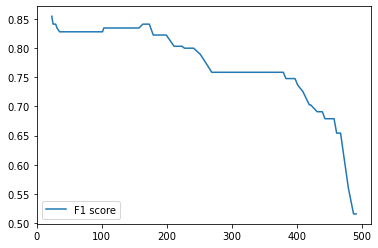

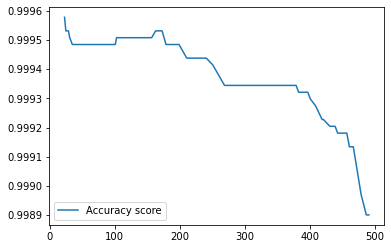

In [14]:
import matplotlib.pyplot as plt
plt.figure(0)
plt.plot(k_values, f1_scores,label='F1 score')
plt.legend(loc="lower left")
#plt.set(xlabel='Neighbours', ylabel='F1 score',label='F1 score evolution for different numbers of neighbors')
plt.show()
plt.figure(1)
plt.plot(k_values, accuracy_scores,label='Accuracy score')
plt.legend(loc="lower left")
#plt.set(xlabel='Neighbours', ylabel='Accuracy score',title='Accuracy score evolution for different numbers of neighbors')
plt.show()

In [15]:
print(f1_scores)

[0.8548387096774194, 0.8412698412698412, 0.8412698412698412, 0.8346456692913387, 0.8281250000000001, 0.8281250000000001, 0.8281250000000001, 0.8281250000000001, 0.8281250000000001, 0.8281250000000001, 0.8281250000000001, 0.8281250000000001, 0.8281250000000001, 0.8281250000000001, 0.8281250000000001, 0.8281250000000001, 0.8281250000000001, 0.8281250000000001, 0.8281250000000001, 0.8281250000000001, 0.8281250000000001, 0.8346456692913387, 0.8346456692913387, 0.8346456692913387, 0.8346456692913387, 0.8346456692913387, 0.8346456692913387, 0.8346456692913387, 0.8346456692913387, 0.8346456692913387, 0.8346456692913387, 0.8346456692913387, 0.8346456692913387, 0.8346456692913387, 0.8412698412698412, 0.8412698412698412, 0.8412698412698412, 0.8412698412698412, 0.8225806451612904, 0.8225806451612904, 0.8225806451612904, 0.8225806451612904, 0.8225806451612904, 0.8225806451612904, 0.8032786885245902, 0.8032786885245902, 0.8, 0.8, 0.8, 0.8, 0.8, 0.7899159663865546, 0.7796610169491526, 0.769230769230

In [16]:
print(accuracy_scores)

[0.9995786714105145, 0.9995318571227939, 0.9995318571227939, 0.9995084499789336, 0.9994850428350732, 0.9994850428350732, 0.9994850428350732, 0.9994850428350732, 0.9994850428350732, 0.9994850428350732, 0.9994850428350732, 0.9994850428350732, 0.9994850428350732, 0.9994850428350732, 0.9994850428350732, 0.9994850428350732, 0.9994850428350732, 0.9994850428350732, 0.9994850428350732, 0.9994850428350732, 0.9994850428350732, 0.9995084499789336, 0.9995084499789336, 0.9995084499789336, 0.9995084499789336, 0.9995084499789336, 0.9995084499789336, 0.9995084499789336, 0.9995084499789336, 0.9995084499789336, 0.9995084499789336, 0.9995084499789336, 0.9995084499789336, 0.9995084499789336, 0.9995318571227939, 0.9995318571227939, 0.9995318571227939, 0.9995318571227939, 0.9994850428350732, 0.9994850428350732, 0.9994850428350732, 0.9994850428350732, 0.9994850428350732, 0.9994850428350732, 0.9994382285473526, 0.9994382285473526, 0.9994382285473526, 0.9994382285473526, 0.9994382285473526, 0.9994382285473526,

In [17]:
for k in range(2,22):
    if checkprime(k):
        k_values = [k] + k_values
        knn = KNeighborsClassifier(n_neighbors = k,p = 2,metric = 'euclidean')
        knn.fit(training_transactions,training_labels)
        predicted_labels = knn.predict(testing_transactions)
        f1_scores= [f1_score(testing_labels,predicted_labels)] + f1_scores
        accuracy_scores = [accuracy_score(testing_labels,predicted_labels)] + accuracy_scores


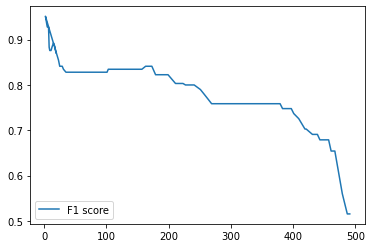

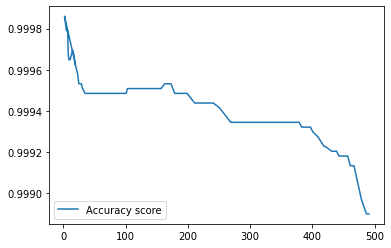

In [18]:
import matplotlib.pyplot as plt
plt.figure(0)
plt.plot(k_values, f1_scores,label='F1 score')
plt.legend(loc="lower left")
plt.show()
plt.figure(1)
plt.plot(k_values, accuracy_scores,label='Accuracy score')
plt.legend(loc="lower left")
plt.show()

The imbalanced dataset makes increasing the k parameter take a big toll on the algorithm's precision. We can fix this by downsampling.

In [4]:
my_csv3 = pd.read_csv(r"D:\Programming shit\Python\MachineLearningDatasets\creditcard.csv")

In [6]:
my_csv3.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


0    284315
1       492
Name: Class, dtype: int64


<AxesSubplot:ylabel='Type'>

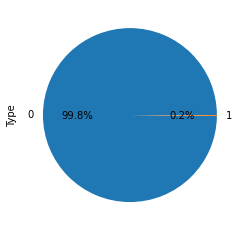

In [9]:
import matplotlib.pyplot as plt

print(my_csv3["Class"].value_counts())
my_csv3.groupby('Class').size().plot(kind='pie',
                                       y = "Class",
                                       label = "Type",
                                       autopct='%1.1f%%')

In [10]:
valid_transactions = my_csv3[my_csv3["Class"] == 1]
invalid_transactions = my_csv3[my_csv3["Class"] == 0]

In [23]:
from sklearn.utils import resample
from math import trunc
valid_downsample = resample(valid_transactions,
             replace=True,
             n_samples=trunc(len(invalid_transactions)),
             random_state=24)

<AxesSubplot:ylabel='Type'>

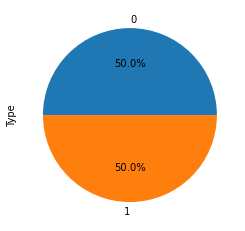

In [24]:
new_dataset = pd.concat([valid_downsample,invalid_transactions])
new_dataset.groupby('Class').size().plot(kind='pie',
                                       y = "Class",
                                       label = "Type",
                                       autopct='%1.1f%%')

In [28]:
new_transactions = new_dataset.iloc[:,0:30]
new_labels = new_dataset.iloc[:,30]
new_training_transactions, new_testing_transactions,new_training_labels,new_testing_labels = train_test_split(new_transactions,new_labels,test_size = .15)
transactions_scaling = StandardScaler()
new_training_transactions = transactions_scaling.fit_transform(new_training_transactions)
new_testing_transactions = transactions_scaling.fit_transform(new_testing_transactions)

In [26]:
new_f1_scores = []
new_k_values = []
new_accuracy_scores = []

In [29]:
from math import sqrt
print(trunc(sqrt(new_training_transactions.shape[0])))

695


In [ ]:
knn = KNeighborsClassifier(n_neighbors = 695,p = 2,metric = 'euclidean')
knn.fit(new_training_transactions,new_training_labels)
new_predicted_labels = knn.predict(new_testing_transactions)
print("F1 score :"+str(f1_score(new_testing_labels,new_predicted_labels)))
print("Accuracy score :" +str(accuracy_score(new_testing_labels,new_predicted_labels)))
